In [ ]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table, join
import os
empty_fits_dir = # insert path to dir with empty_direct.fits and empty_seg.fits
os.chdir(empty_fits_dir)

# Pretty plots
import matplotlib
matplotlib.rcParams["figure.figsize"] = (11,6)
matplotlib.rcParams["image.interpolation"] = "nearest"
matplotlib.rcParams["image.origin"] = "lower"

# Grizli stuff
from grizli.model import GrismFLT
import pysynphot as S
import webbpsf
import webbpsf.roman

In [ ]:
bandpass_file = # insert path to wfirst_wfi_f158_001_syn.fits or other bandpass file
spec_file = # insert path to ukg0v.dat or other spectrum file

# Read SED template; using G0V star template
df = Table.read(bandpass_file, format='fits')
bp = S.ArrayBandpass(df["WAVELENGTH"], df["THROUGHPUT"])

# Adjust spectrum as appropriate
spec = Table.read(spec_file, format="ascii")
src = S.ArraySpectrum(wave=spec["col1"], flux=spec["col2"], waveunits="angstroms", fluxunits="flam")
src = src.renorm(6, "abmag", bp)
src.convert("flam")

# TODO: use the renormalized src instead of spec, or renorm spec
spec = spec[1770:3771] # truncate spectrum to 10000-20000 angstroms

# PSF
wfi = webbpsf.roman.WFI()
# webbpsf.setup_logging("Error")

In [15]:
# initialize grizli
pad = 100
roman = GrismFLT(direct_file="empty_direct.fits", seg_file="empty_seg.fits", pad=pad);

Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
empty_direct.fits / Pad ref HDU with 264 pixels
empty_direct.fits / blot segmentation empty_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...


In [16]:
def chunk(start_wave, end_wave):
    """
    This function returns a small region of the spectrum.
    """
    start_index = int((start_wave - 10000) / 5)
    end_index = int((end_wave - 10000) / 5) + 1

    chunk_spec = np.asarray(spec[start_index:end_index])

    return chunk_spec

def dispersion_model(spectrum_overlap, npsfs, return_input=False):
    """
    This function controls/guides the dispersion process. It sets up the appodizing window,
    chops the spectrum into smaller segments, and iteratively disperses each segment. If 
    return_input is True, it returns a list containing the input segments then the grism sim.
    The input segments can be stitched together using the combine_overlaps function below. 

    Parameters
    ----------

    spectrum_overlap: int
        The number of data points that overlap as spectrum segments roll-on/off.
    
    npsfs: int
        The number of distinct PSFs to be used. Also, the number of spectrum segments.
    """
    spectrum_overlap = int(spectrum_overlap) # overlap extent; data points
    npsfs = int(npsfs) # number of bins

    window_x = np.linspace(0, np.pi, spectrum_overlap)
    front_y = (1-np.cos(window_x)) / 2
    back_y = 1 - front_y

    bins = np.linspace(10000, 20000, npsfs + 1)

    piecemeal_sim = np.zeros((4288,4288))

    input_catcher = []
    
    for ii, start_wave in enumerate(bins[:-1]):

        psf = wfi.calc_psf(monochromatic=(start_wave * (10**-10)), fov_pixels=364, oversample=1, source=src)[0].data
        half_psf_thumb = int(psf.shape[0] / 2) # Used for indexing; center_pixel plus/minus half_psf_thumb(nail)
        
        direct = np.zeros((4288, 4288))
        direct[(2144-half_psf_thumb): (2144+half_psf_thumb), (2144-half_psf_thumb):(2144+half_psf_thumb)] = psf

        roman.direct.data["SCI"] = direct.astype("float32")
        roman.seg = np.where(roman.direct.data["SCI"], 1, 0).astype("float32")

        end_wave = bins[ii+1]

        start_wave -= (spectrum_overlap * 5) * 0.5 # times 5 from indicies to wavelength
        end_wave += ((spectrum_overlap - 1) * 5) * 0.5

        if start_wave < 10000:
            start_wave = 10000
        
        if end_wave > 20000:
            end_wave = 20000

        chunk_spec = chunk(start_wave, end_wave) # extract relevant part of spectrum
        wave = chunk_spec["col1"]
        flux = chunk_spec["col2"]

        # apodize
        if start_wave != 10000:
            flux[:spectrum_overlap] *= front_y

        if end_wave != 20000:
            flux[-spectrum_overlap:] *= back_y

        # print("Wave Limits: [{}, {}]".format(wave[0], wave[-1])) # used for troubleshooting
        
        single_dispersion = roman.compute_model_orders(id=1, mag=1, compute_size=False, size=500, is_cgs=True, store=False,
                                                       in_place=False, spectrum_1d=[wave, flux])[1]

        piecemeal_sim += single_dispersion

        apodized_spec = Table([wave, flux], names=("wave","flux"))

        input_catcher.append(apodized_spec)

        del chunk_spec
        del flux
        del wave

    return_collector = []

    if return_input:
        return_collector.append(input_catcher)

    return_collector.append(piecemeal_sim)

    return return_collector

def combine_overlaps(table_1, table_2):
    """
    This function can be used in a for loop to stitch together the input spectrum segments.
    """

    full_input = join(table_1, table_2, keys='wave', join_type="outer")

    full_input["flux_1"].fill_value = 0
    full_input["flux_2"].fill_value = 0
    full_input = full_input.filled()

    sum = full_input["flux_1"] + full_input["flux_2"]

    sum_table = Table([full_input["wave"], sum], names=["wave", "flux"])

    return sum_table

def simple_extractions(image, sum=True, max=False):
    """
    Scans along the columns of the pixel array. Hyper-simplified "extraction."
    """

    return_collector = []

    if sum:
        return_collector.append(np.array([image[:, ii].sum() for ii in range(image.shape[1])]))
    
    if max:
        return_collector.append(np.array([image[:, ii].max() for ii in range(image.shape[1])]))

    return return_collector

In [17]:
# Run the simulation
spectrum_overlap = 20
npsfs = 20

inputs, sim_result = dispersion_model(spectrum_overlap, npsfs, return_input=True)

In [18]:
# Combine all inputs into a single array
for ii in range(len(inputs)):
    if ii == 0:
        full_input = inputs[0]
    else:
        full_input = combine_overlaps(full_input, inputs[ii])

# Perform simple_extractions
extractions = simple_extractions(sim_result, sum=True, max=True)

Text(0.5, 1.0, 'Extractions')

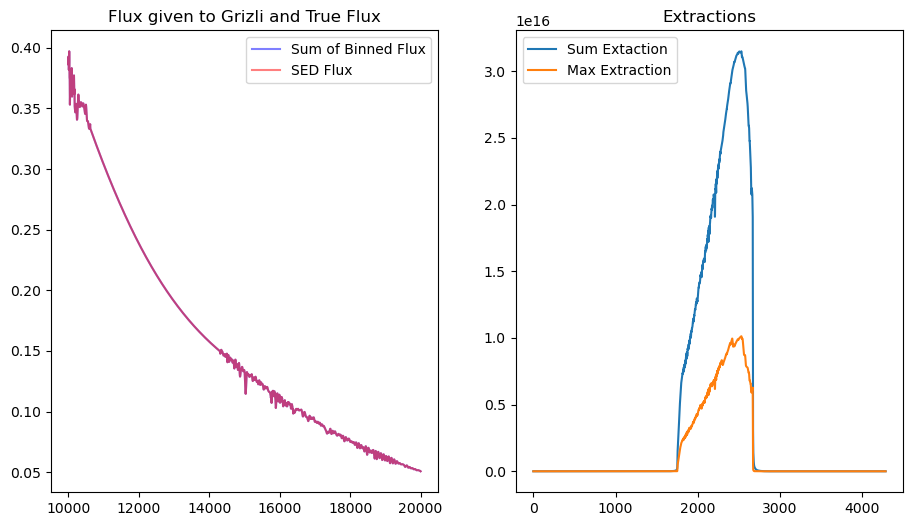

In [19]:
# Plot the inputs and extractions
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(full_input["wave"], full_input["flux"], color='b', alpha=0.5, label="Sum of Binned Flux")
ax1.plot(spec["col1"], spec["col2"], color = 'r', alpha=0.5, label="SED Flux")
ax1.legend()
ax1.set_title("Flux given to Grizli and True Flux")

ax2.plot(extractions[0], label="Sum Extaction")
ax2.plot(extractions[1], label="Max Extraction")
ax2.legend()
ax2.set_title("Extractions")

In [20]:
# Calculate a simple, single-PSF model for comparison
truth = roman.compute_model_orders(id=1, mag=1, compute_size=False, size=500, is_cgs=True, 
                                   store=False, in_place=False, spectrum_1d=[spec["col1"], spec["col2"]])[1]

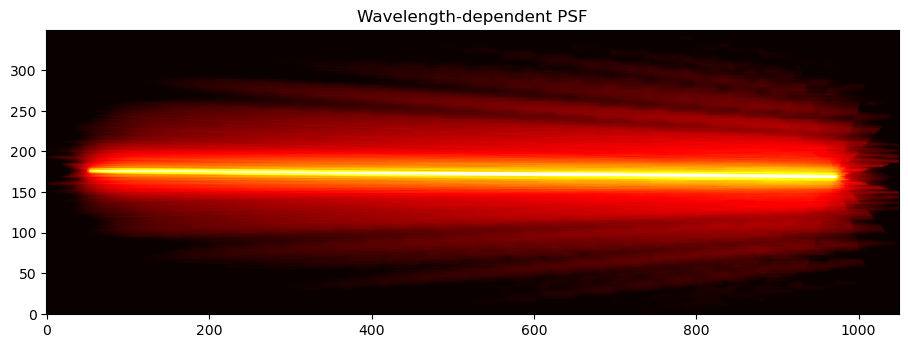

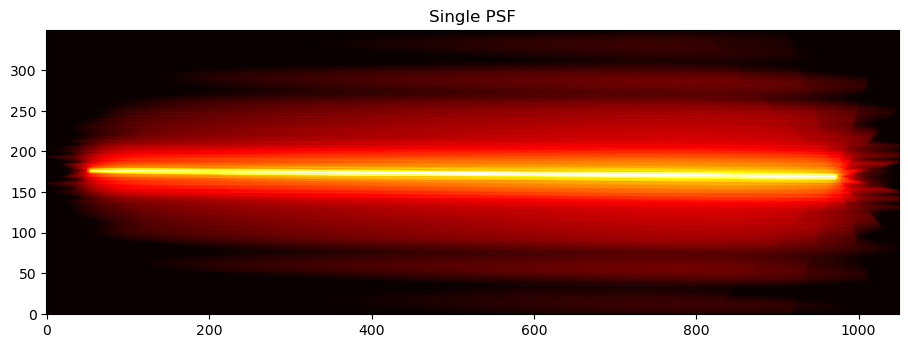

In [24]:
plt.imshow(np.log(sim_result[2000:2350, 1700:2750])-26, vmin=0, vmax=10, cmap="hot")
plt.title("Wavelength-dependent PSF")
plt.show()

plt.imshow(np.log(truth[2000:2350, 1700:2750])-26, vmin=0, vmax=10, cmap="hot")
plt.title("Single PSF")
plt.show()

Text(0.5, 1.0, 'Subtract Wavelength-depdent PSF dispersion from Single PSF disperion')

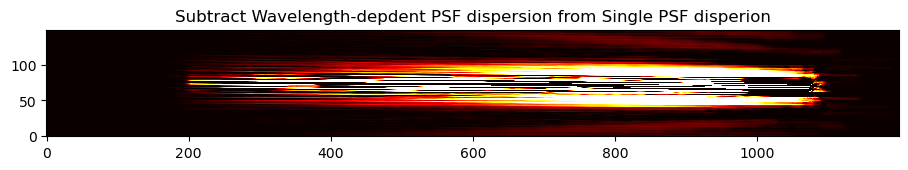

In [40]:
plt.imshow((truth-sim_result)[2100:2250, 1600:2800], vmin=0, vmax=sim_result.max()/1000, cmap="hot")
plt.title("Subtract Wavelength-depdent PSF dispersion from Single PSF disperion")

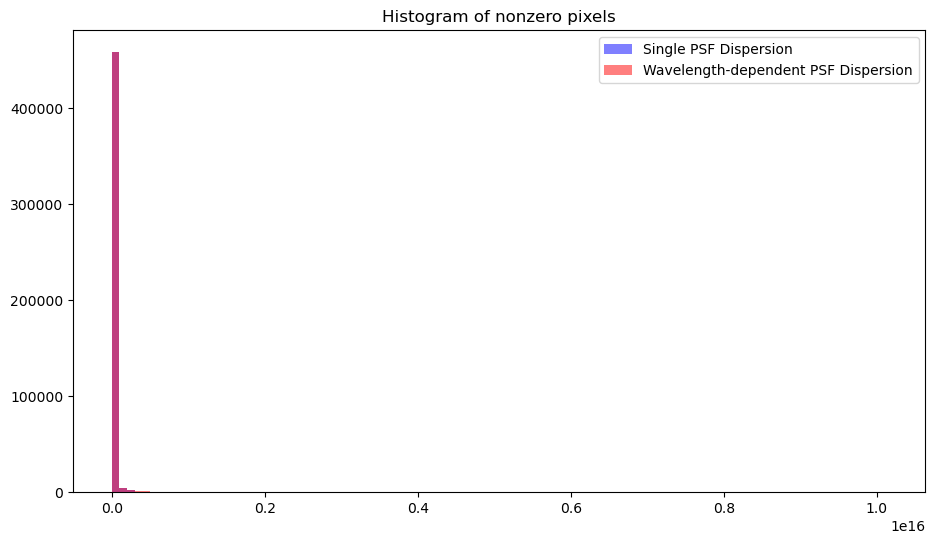

In [23]:
plt.hist(truth[np.nonzero(truth)].flatten(), bins=100, color="b", alpha=0.5, label="Single PSF Dispersion");
plt.hist(sim_result[np.nonzero(sim_result)].flatten(), bins=100, color="r", alpha=0.5, label="Wavelength-dependent PSF Dispersion");
plt.title("Histogram of nonzero pixels")
plt.legend()